# Baesyan Data Analysis Course - Chapter 5 Exercises
https://github.com/avehtari/BDA_course_Aalto/tree/master/exercises

## Generalized linear model: Bioassay with Metropolis
Metropolis algorithm: Replicate the computations for the bioassay
example of section 3.7 (BDA3) using the Metropolis algorithm. The Metropolis algorithm is described in BDA3 Chapter 11.2. More information on the bioassay data can be found in Section 3.7 of the course book and in chapter 3 reading instructions \href{https://github.com/avehtari/BDA_course_Aalto/blob/master/chapter_notes/BDA_notes_ch3.pdf}{\textbf{here}}.

### Exercise 1
Implement the Metropolis algorithm as an R function for the bioassay data. Use the Gaussian prior as in Assignment 4, that is
\begin{align*}
    \begin{bmatrix}
    \alpha \\ \beta
    \end{bmatrix}
    \sim
    \text{N} \left( \mathbf{\mu_0}, \mathbf{\Sigma_0} \right), \qquad
    \text{where} \quad
    \mathbf{\mu_0} = \begin{bmatrix} 0 \\ 10 \end{bmatrix} \quad \text{and} \quad
    \mathbf{\Sigma_0} = \begin{bmatrix} 2^2 & 10 \\ 10 & 10^2 \end{bmatrix}.
\end{align*}

**a)** Start by implementing a function called *density\_ratio* to compute the density ratio function, $r$ in Eq. (11.1) in BDA3.

**Answer:** The density ratio is defined as

$$r = \dfrac{p(\theta_{t}|y)}{p(\theta_{t-1}|y)}$$

where $\theta_t$ is a new sample from the proposal distribution, and $\theta_{t-1}$ is the last sample from the proposal.

In [2]:
from scipy.stats import multivariate_normal as mvn
from scipy.special import binom
import numpy as np

def sigmoid(x):
    return 1/(1+np.exp(-1*np.array(x)))

# could be improved by considering the stufficient statistics
def log_likelihood(α, β, x, y, n):
    z = sigmoid(α + β*x)
    eps = 1e-12
    z = np.array([min(z[i], 1 - eps) for i in range(len(z))])
    z = np.array([max(z[i], eps) for i in range(len(z))])
    return y@np.log(z) + (n-y)@np.log((1-z))

def prior(α, β):
    Σ = np.array([[2**2, 10],
            [10, 10**2]])
    μ = [0, 10]
    return mvn.pdf([α, β], mean=μ, cov=Σ)

def posterior(α, β, x, y, n):
    return np.exp(np.log(prior(α, β)) + log_likelihood(α, β, x, y, n))

def density_ratio(α_prop, α_prev, β_prop, β_prev, x, y, n):
    return posterior(α_prop, β_prop, x, y, n) / posterior (α_prev, β_prev, x, y, n)
    

In [3]:
# bioassay data
import pandas as pd
dat = pd.read_csv('Data//bioassay.txt', sep=" ")

# test cases
print("test case 1: %.6f" % density_ratio(1.89, 0.374, 24.76, 20.04,
             dat['x'], dat['y'], dat['n']))

print("test case 2: %.6f" % density_ratio(0.374, 1.89, 20.04, 24.76,
             dat['x'], dat['y'], dat['n']))

test case 1: 1.187524
test case 2: 0.842088


**b)** Now implement a function called *metropolis\_bioassay()* which implements the metropolis algorithm  using the *density\_ratio()*. Use a simple (normal) proposal distribution.

In [4]:
from scipy.stats import uniform, norm
def metropolis_prop(α_prev, β_prev, x, y, n, σ_pα, σ_pβ):
    '''inputs: α_prev, β_prev: previous values from the chain, used to compute the density ratio
                x: univariate covariate, y: number of deaths (dependent variable), n: vector with number of rats
                x, y and n are used to calculate the likelihood (and the posterior)
                the goal is to draw β_prob and β_prob from the posterior distribution of α and β;
                σ_pα and σ_pβ are parameters (std. dev) from the Metropolis proposal distribution, which in this case
                is assumed to be N(α_prev, σ_pα) and N(β_prev, σ_pβ)
                
        returns a proposal draw (α, β) from the posterior of p(α, β|y)'''
    α_prop, β_prop = norm.rvs(α_prev, σ_pα), norm.rvs(β_prev, σ_pβ)
    r = density_ratio(α_prop, α_prev, β_prop, β_prev, x, y, n)
    unif_draw = uniform.rvs()
    if unif_draw <= r:
        return np.array([α_prop, β_prop])
    else:
        return np.array([α_prev, β_prev])

def metropolis_bioassey(x, y, n, chain_len, warmup_len, σ_pα, σ_pβ, α_0 = 0, β_0 = 0):
    '''Chain for α and β
    
    Parameters
    ----------
    x : univariate covariate vector from bioassay experiment (dosage in each experiment)
    y : vector with number of deaths in a given experiment
    n : vector with number of samples in a given experiment
    chain_len : number of posterior samples draws returned
    warmup_len : length of warm-up, i.e., warmup_len + chain_len draws will be made, and only chain_len draws returned
    σ_pα, σ_pβ : proposal distribution std. deviation. Proposal distribution is norm(loc = previous_valus, scale = σ_p)
    α_0, β_0 : initial values for the chain
    
    Returs:
    -------
    α_draws : a sequence of α draws from the joint posterior
    β_draws : a sequence of β draws from the joint posterior
    
    '''
    n_samples = warmup_len + chain_len - 1
    prev = np.array([α_0, β_0])
    draws = np.array([prev])
    for k in range(n_samples):
        prev = metropolis_prop(prev[0], prev[1], x, y, n, σ_pα, σ_pβ)
        draws = np.append(draws, np.array([prev]), axis = 0)
    
    return draws[warmup_len:(chain_len+1)]

def starting_points():
    '''not really theoretically based, but just a away to have some stating points for the algorithm'''
    Σ = np.array([[3**2, 0],
            [0, 12**2]])
    μ = [0, 10]
    return mvn.rvs(mean=μ, cov=Σ)

### Exercise 2 - Reporting Results: chains and chain convergence

Include in the report the following:

**a)** The jumping rule (other name for the proposal distribution).

**Answer:** The proposal distribution is $j(\alpha) = N(\alpha_{t-1}, \sigma_{p\alpha}^2)$ and $j(\beta) = N(\beta_{t-1}, \sigma_{p\beta}^2)$. A first try will be made with $(\sigma_{p\alpha}, \sigma_{p\beta}) = (1, 5)$.

**b)** The starting points of your metropolis chains (or the mechanism for generating them).

**Answer:** An OK approach would be to consider $E(\theta|y)$ from the Importance Sampling of Ex. 4 as starting points. But since I want to try different starting points, I'll use a Multivariate normal distribution to generate random starting values. such distribution have mean and covariance given by

\begin{align*}
    \mathbf{\mu} = \begin{bmatrix} 0 \\ 10 \end{bmatrix} \quad \text{and} \quad
    \mathbf{\Sigma} = \begin{bmatrix} 2^2 & 0 \\ 0 & 10^2 \end{bmatrix}.
\end{align*}

**c)** Report the chain length or the number of draws from each chain. Run the simulations long enough for approximate convergence.

**d)** Report the warm-up length.

**e)** The number of metropolis chains used. It is a important that multiple metropolis chains be run for evaluating convergence.

**f)** Plot all chains for alpha (line plot) in a single plot, overlapping chains help in visually assessing whether chains have converged or not.

**g)** Do the same for beta.

**Answer:** A "long" chain of length 1000 was simulated. The warm up chosen is 0.5 of the chain length, i.e., 500. 5 chains were simulated.

In [168]:
# creating chains
from time import time
from random import seed

starting_time = time()

σ_pα, σ_pβ = 2, 10
# create number_of_chains chains
number_of_chains = 3
chain_len = 10000
seed(123)
for k in range(number_of_chains):
    θ_0 = starting_points()
    vars()["chain_"+str(k+1)] = metropolis_bioassey(dat['x'], dat['y'], dat['n'], 
                                                    chain_len = chain_len, warmup_len = 0, 
                                                    σ_pα = σ_pα, σ_pβ = σ_pβ, α_0 = θ_0[0], β_0 = θ_0[1])
b = time() - starting_time
print("took %.2f secs. to create %i chains of length %i" % (b, number_of_chains, chain_len) )

took 36.76 secs. to create 3 chains of length 10000


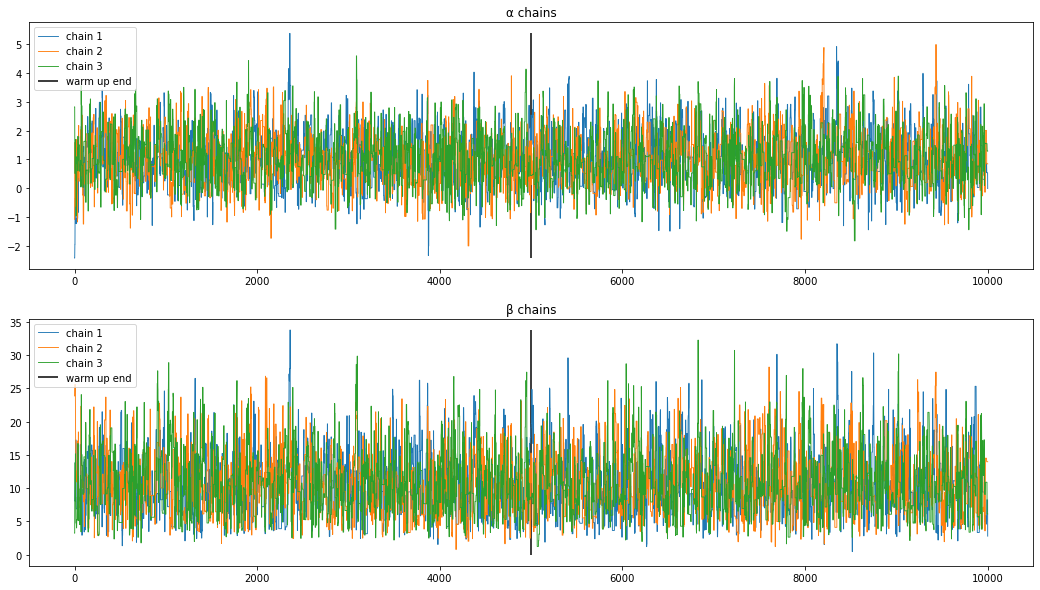

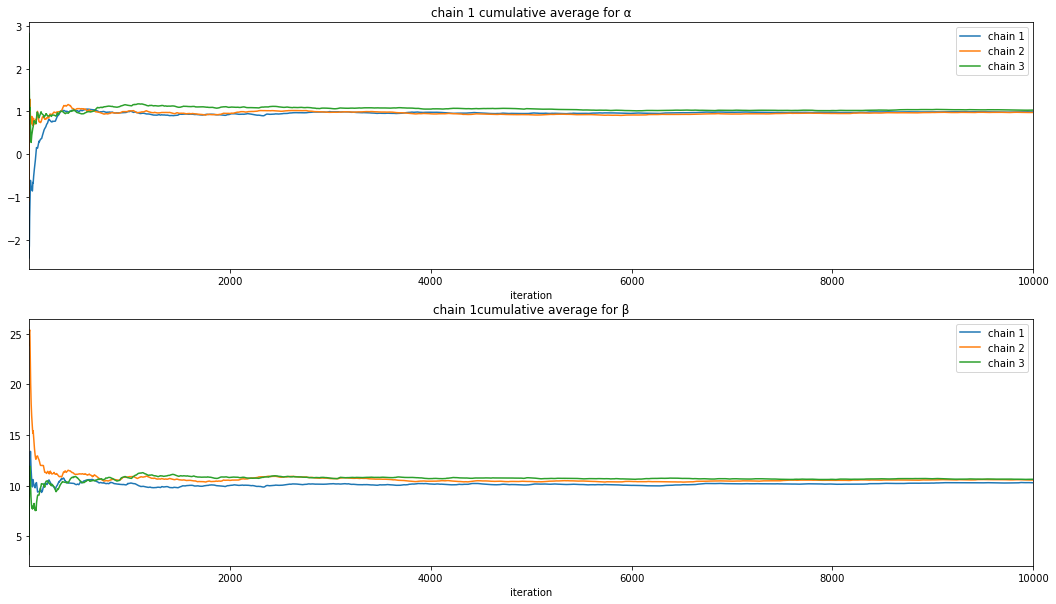

In [61]:
# plotting chains to check convergence
import matplotlib.pyplot as plt

burnin = chain_len//2
indexes = np.arange(burnin, chain_len)
fig, axes = plt.subplots(nrows = 2, figsize = (18,10))

parnames = ["α", "β"]
for i in range(2):
    ymin, ymax = 0, 0
    for k in range(number_of_chains):
        this_chain = globals()["chain_"+str(k+1)][:, i]
        axes[i].plot(np.linspace(1, chain_len, num = chain_len), this_chain,
                     linewidth=0.9,
                     label = "chain "+str(k+1))
        if max(this_chain) > ymax:
            ymax = max(this_chain)
        if min(this_chain) < ymin:
            ymin = min(this_chain)
            
    axes[i].vlines(burnin, ymin=ymin, ymax=ymax, label = "warm up end")
    axes[i].legend()
    axes[i].set_title(parnames[i] + " chains")
plt.show()

# Plotting cumulative averages for beta and alpha behavior separately. All samples
fig, axes = plt.subplots(nrows = 2, figsize = (18,10))
for i in range(2):
    for k in range(number_of_chains):
        samps = globals()["chain_"+str(k+1)][:, i]
        axes[i].plot(
            np.linspace(1, chain_len, num = chain_len),
            np.cumsum(samps, axis=0)/np.arange(1,len(samps)+1), # cumulative sum divided by the number of samples
            label = "chain "+str(k+1))
    axes[i].set_xlabel('iteration')
    if i == 0:
        axes[i].set_title('chain 1 cumulative average for α')
    else:
        axes[i].set_title('chain 1cumulative average for β')
    axes[i].set_xlim([1, chain_len])
    axes[i].legend()

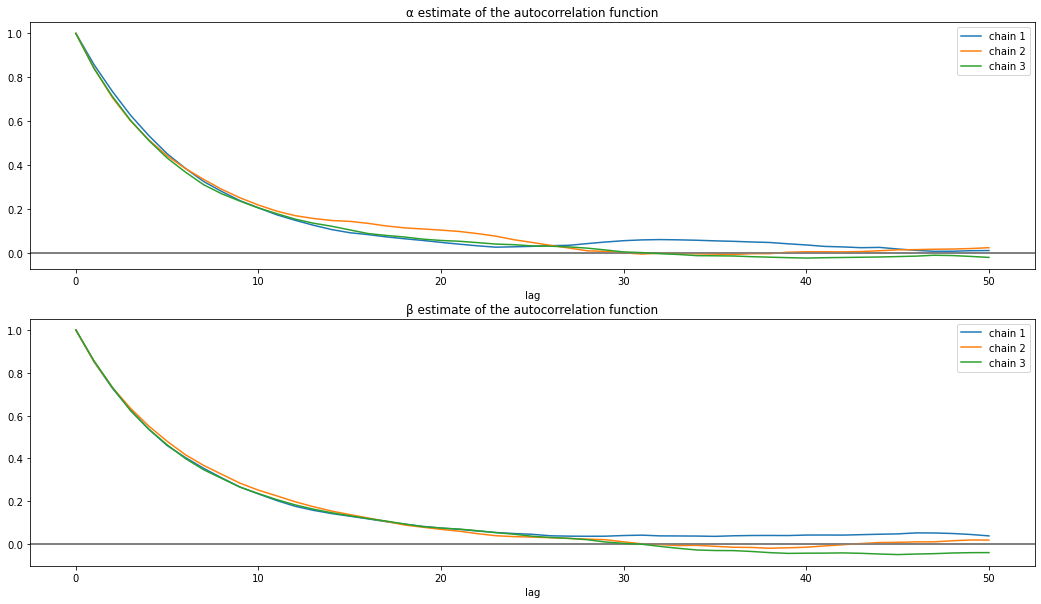

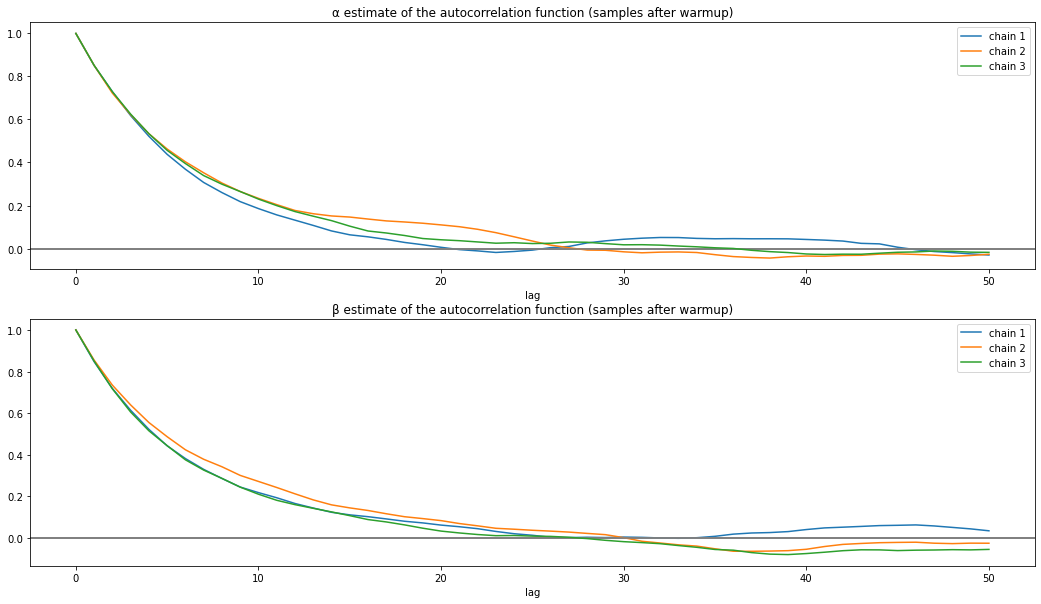

In [62]:
# Plotting estimated autocorrelation for beta and alpha behavior separately. All samples
fig, axes = plt.subplots(nrows = 2, figsize = (18,10))
for i in range(2):
    for k in range(number_of_chains):
        samps = globals()["chain_"+str(k+1)][:, i]
        maxlag = 50 # maximum lag for autocorrelation
        sampsc = samps - np.mean(samps) # scale the samples by deducting the mean
        acorlags = np.arange(maxlag+1) # lags from 0 to maxlag
        
        axes[i].axhline(y=0, color='gray')
        # calculate autocorrelation for all different lags
        t = np.correlate(sampsc, sampsc, 'full') # autocorrelation with full range of lags
        t = t[-len(sampsc):-len(sampsc)+maxlag+1] / t[-len(sampsc)] # choose only the lags that we want to use
        axes[i].plot(acorlags, t, label = "chain "+str(k+1))
    axes[i].legend()
    axes[i].set_xlabel('lag')
    if i == 0:
        axes[i].set_title('α estimate of the autocorrelation function')
    else:
        axes[i].set_title('β estimate of the autocorrelation function')
        
        
# Plotting estimated autocorrelation for beta and alpha behavior separately. Only samples after warm-up included.
fig, axes = plt.subplots(nrows = 2, figsize = (18,10))
for i in range(2):
    for k in range(number_of_chains):
        samps = globals()["chain_"+str(k+1)][burnin:, i]
        maxlag = 50 # maximum lag for autocorrelation
        sampsc = samps - np.mean(samps) # scale the samples by deducting the mean
        acorlags = np.arange(maxlag+1) # lags from 0 to maxlag
        
        axes[i].axhline(y=0, color='gray')
        # calculate autocorrelation for all different lags
        t = np.correlate(sampsc, sampsc, 'full') # autocorrelation with full range of lags
        t = t[-len(sampsc):-len(sampsc)+maxlag+1] / t[-len(sampsc)] # choose only the lags that we want to use
        axes[i].plot(acorlags, t, label = "chain "+str(k+1))
    axes[i].legend()
    axes[i].set_xlabel('lag')
    if i == 0:
        axes[i].set_title('α estimate of the autocorrelation function (samples after warmup)')
    else:
        axes[i].set_title('β estimate of the autocorrelation function (samples after warmup)')

### Exercise 3 - more chain convergence check
In complex scenarios, visual assessment is not sufficient and $\hat{R}$ is a more robust indicator of convergence of the metropolis chains. Use $\hat{R}$ for convergence analysis. You can either use Eq. (11.4) in BDA3 or the later version that can be found [here](https://arxiv.org/abs/1903.08008). You should specify which $\hat{R}$ you used. Remember to remove the warm-up samples before computing $\hat R$. Report also the $\hat R$ values for $\alpha$ and $\beta$ separately, and discuss the convergence of the chains.
**This means that you should briefly explain how to interpret the obtained** $\hat R$ **values**.

In [169]:
### splits all chains in half, and stores them in a (mxn) vector, where m is the number of chains times 2, and n in the length 
### of each chain (chain_len//4)

alpha_chains = np.array([np.zeros(chain_len//4) for k in range(2*number_of_chains)])
beta_chains = np.copy(alpha_chains)

for k in range(number_of_chains):
    split_a1 = globals()["chain_"+str(k+1)][burnin:, 0][:chain_len//4]
    split_a2 = globals()["chain_"+str(k+1)][burnin:, 0][chain_len//4:]
    split_b1 = globals()["chain_"+str(k+1)][burnin:, 1][:chain_len//4]
    split_b2 = globals()["chain_"+str(k+1)][burnin:, 1][chain_len//4:]
    
    alpha_chains[k] = split_a1
    alpha_chains[number_of_chains + k] = split_a2
    beta_chains[k] = split_b1
    beta_chains[number_of_chains + k] = split_b2

In [170]:
### functions to calculate R-hat. chains is a (mxn) array, with elemtent chain_ji the i-th element of the j-th chain;
def get_phi_j(chains):
    n = np.shape(chains)[1]
    return np.sum(alpha_chains, axis=1)/n

def B(chains):
    m = np.shape(chains)[0]
    n = np.shape(chains)[1]
    phi_j = get_phi_j(chains)
    phi = 1/m*sum(phi_j)
    return n/(m-1)*sum( (phi_j-phi)**2 )

def W(chains):
    m = np.shape(chains)[0]
    n = np.shape(chains)[1]
    phi_j = get_phi_j(chains)
    
    s_j = np.array([ 1/(n-1)*sum((chains[j, :] - phi_j[j])**2) for j in range(m)])
    return 1/m*sum(s_j)

def R_hat(chains):
    m = np.shape(chains)[0]
    n = np.shape(chains)[1]
    var = (n-1)/n*W(chains) + 1/n*B(chains)
    return np.sqrt(var/W(chains))
    
# see paper and report R-hat
# big R-hat: >1.01
print ("R-hat for α chains: %.4f \nR-hat for β chains: %.10f" %(R_hat(alpha_chains), R_hat(beta_chains)))

R-hat for α chains: 1.0012 
R-hat for β chains: 0.9998100411


The $\hat R$ values were obtained using split$\hat R$, as reported in BDA3 Eq. 11.4 (pg. 284). The values for $\alpha$ simulated chains indicates that evidence for good mixing of MCMC chains/empirical evidence for good MCMC convergence, since its values are greater than $1$ and $\leq 1.01$.

The $\hat R$ for $\beta$ chains indicates the same, but are $\leq 1$. This should not happend usually, but it can happen if chains are stated underdispersed, have short warmup or are short. Maybe the case here is underdispersed initialization, but I'm not sure. Could also be a rouding error, but not likely. Could also be a bug in the code.

### Exercise 4 - plotting posterior draws
Plot the draws for $\alpha$ and $\beta$ (scatter plot) and include this plot in your report. You can compare the results to Figure 3.3b in BDA3 to verify that your code gives sensible results. Notice though that the results in Figure 3.3b are generated from posterior with a uniform prior, so even when your algorithm works perfectly, the results will look slightly different (although fairly similar).

In [64]:
alpha = np.array([])
beta = np.array([])
for k in range(number_of_chains):
    this_chain = globals()["chain_"+str(k+1)][burnin:, :]
    alpha = np.concatenate((alpha, this_chain[:, 0]))
    beta = np.concatenate((beta, this_chain[:, 1]))

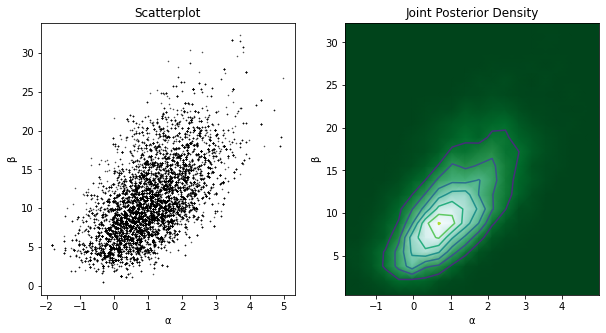

Posterior mean for α: 1.02 
Posterior mean for β: 10.57
95% C.I for α: [-0.65, 2.93] 
95% C.I for β: [3.38, 21.04]


In [233]:
from scipy.stats import kde
# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

# Scatterplot
axes[0].set_title('Scatterplot')
axes[0].scatter(alpha, beta, s = 0.3, color = "black", alpha = 0.7)
axes[0].set_xlabel("α")
axes[0].set_ylabel("β")

nbins = 20
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde((alpha, beta))
xi, yi = np.mgrid[alpha.min():alpha.max():nbins*1j, beta.min():beta.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# density with shading and contour
axes[1].set_title('Joint Posterior Density')
axes[1].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
axes[1].contour(xi, yi, zi.reshape(xi.shape) )
axes[1].set_xlabel("α")
axes[1].set_ylabel("β")

plt.show()

def get_quantile(chain):
    sorted_chain = np.sort(chain)[int(0.025*len(chain)):int(0.975*len(chain))]
    return np.array([min(sorted_chain), max(sorted_chain)])

a95 = get_quantile(alpha)
b95 = get_quantile(beta)

print("Posterior mean for α: %.2f \nPosterior mean for β: %.2f" %(np.mean(alpha), np.mean(beta)))
print("95% C.I for α: [{0}, {1}] \n95% C.I for β: [{2}, {3}]".format(*np.append(np.round(a95,2), np.round(b95,2))))